# importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# utilities

In [2]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def relu(z):
    return np.maximum(0, z)

def logloss(y_true, y_pred, eps=1e-15):
    y_pred = np.clip(y_pred, eps, 1 - eps)
    return -(y_true * np.log(y_pred)).sum(axis=1).mean()
    

# data exploration

In [3]:
data = pd.read_csv('sample_data/heart.csv')

In [4]:
print('........Head..........')
print(data.head())

........Head..........
    age  anaemia  creatinine_phosphokinase  diabetes  ejection_fraction  \
0  75.0        0                       582         0                 20   
1  55.0        0                      7861         0                 38   
2  65.0        0                       146         0                 20   
3  50.0        1                       111         0                 20   
4  65.0        1                       160         1                 20   

   high_blood_pressure  platelets  serum_creatinine  serum_sodium  sex  \
0                    1  265000.00               1.9           130    1   
1                    0  263358.03               1.1           136    1   
2                    0  162000.00               1.3           129    1   
3                    0  210000.00               1.9           137    1   
4                    0  327000.00               2.7           116    0   

   smoking  time  DEATH_EVENT  
0        0     4            1  
1        0     6 

In [5]:
print('........Info..........')
print(data.info())

........Info..........
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.

In [6]:
print('........describe..........')
print(data.describe())

........describe..........
              age     anaemia  creatinine_phosphokinase    diabetes  \
count  299.000000  299.000000                299.000000  299.000000   
mean    60.833893    0.431438                581.839465    0.418060   
std     11.894809    0.496107                970.287881    0.494067   
min     40.000000    0.000000                 23.000000    0.000000   
25%     51.000000    0.000000                116.500000    0.000000   
50%     60.000000    0.000000                250.000000    0.000000   
75%     70.000000    1.000000                582.000000    1.000000   
max     95.000000    1.000000               7861.000000    1.000000   

       ejection_fraction  high_blood_pressure      platelets  \
count         299.000000           299.000000     299.000000   
mean           38.083612             0.351171  263358.029264   
std            11.834841             0.478136   97804.236869   
min            14.000000             0.000000   25100.000000   
25%          

<AxesSubplot:>

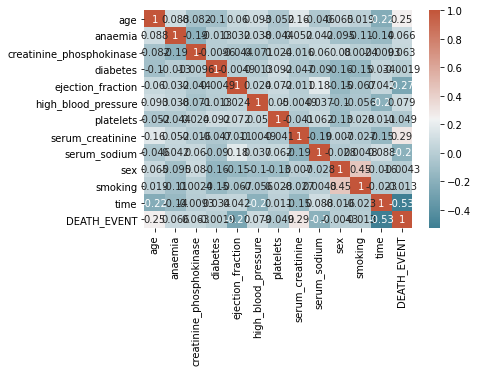

In [8]:

corr = data[data.columns][:].corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))

# Preprocessing

In [9]:
X = data.iloc[:, 0:-1].values
Y = data.iloc[:, -1].values


X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.2,random_state=42)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

X_train = X_train.T
y_train = y_train.reshape(1, len(y_train))
X_test = X_test.T
y_test = y_test.reshape(1, len(y_test))

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(12, 239)
(1, 239)
(12, 60)
(1, 60)


# Algo

In [10]:

def initialize_parameters(n_units):
    parameters = {}
    # print(n_units)
    for l in range(1, len(n_units)):
        parameters['W'+str(l)] = np.random.rand(n_units[l], n_units[l-1]) * 0.01
        parameters['b'+str(l)] = np.zeros((n_units[l], 1))
    
    return parameters

def forward_propogation(X, parameters, L):
    # forward
    A = {}
    Z = {}
    A['0'] = X
    # print(X.shape)
    # for l in range(1, L):
    #     print(l, parameters['W'+str(l)].shape, parameters['b'+str(l)].shape)
    for l in range(1, L):
        Z[str(l)] = np.dot(parameters['W'+str(l)], A[str(l-1)]) + parameters['b'+str(l)]
        A[str(l)] = relu(Z[str(l)])
        # print(A[str(l)].shape)
    Z[str(L)] = np.dot(parameters['W'+str(L)], A[str(L-1)]) + parameters['b'+str(L)]
    A[str(L)] = sigmoid(Z[str(L)])

    return A, Z

def backward_propogation(A, Z, Y, L):
    N = X.shape[1]
    dA = {}
    dZ = {}
    gradients = {}
    dZ[str(L)] = A[str(L)] - Y
    gradients['dW'+str(L)] = np.dot(dZ[str(L)], A[str(L-1)].T) / N
    gradients['db'+str(L)] = np.sum(dZ[str(L)], axis=1).reshape((dZ[str(L)].shape[0], 1)) / N

    for l in reversed(range(1, L)):
        dA[str(l)] = np.dot(parameters['W'+str(l+1)].T, dZ[str(l+1)])
        dZ[str(l)] = dA[str(l)]*(Z[str(l)] >= 0)
        gradients['dW'+str(l)] = np.dot(dZ[str(l)], A[str(l-1)].T) / N
        gradients['db'+str(l)] = np.sum(dZ[str(l)], axis=1).reshape((dZ[str(l)].shape[0], 1)) / N
    
    return gradients

def propagate(X, parameters, Y, L):

    A, Z = forward_propogation(X, parameters, L)
    loss = logloss(A[str(L)], Y)

    cost = np.mean(loss)
    
    gradients = backward_propogation(A, Z, Y, L)

    return cost, gradients

def update_parameters(parameters, gradients, learning_rate, L):

    for l in range(1, L+1):
        parameters['W'+str(l)] -= learning_rate * gradients['dW'+str(l)]
        parameters['b'+str(l)] -= learning_rate * gradients['db'+str(l)]
    
    return parameters


# gradient descent
nx = X_train.shape[0]
# layer_node_cnt = [X_train.shape[0], 15, 1]
n_units = [nx, 15, 1]
L = len(n_units) - 1
n_epochs = 2000
learning_rate = 0.001
parameters = initialize_parameters(n_units)


costs = []
for _ in range(n_epochs):
    cost, gradients = propagate(X_train, parameters, y_train, L)
    costs.append(cost)
    parameters = update_parameters(parameters, gradients, learning_rate, L)

# plotting cost

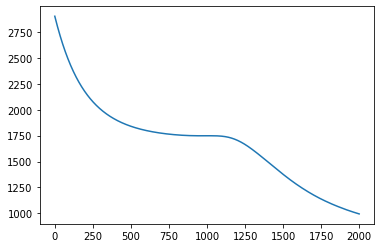

In [11]:
plt.plot(range(len(costs)), costs)

# making predictions

In [12]:
def accuracy(y_pred, y):
    y_pred = y_pred.T
    y = y.T

    ecnt = 0
    for yp, yt in zip(y_pred, y):
        ecnt += int(yp == yt)
    return (ecnt/len(y_pred))*100

def predict(X, y, parameters, L):
    
    A, Z = forward_propogation(X, parameters, L)
    y_pred = (A[str(L)] >= 0.5).astype(int)
    return accuracy(y_pred, y)

print(f'Training Accuracy: {predict(X_train, y_train, parameters, L)}')
print(f'Testing Accuracy: {predict(X_test, y_test, parameters, L)}')


Training Accuracy: 86.19246861924687
Testing Accuracy: 80.0
